# スラスターの補正機能

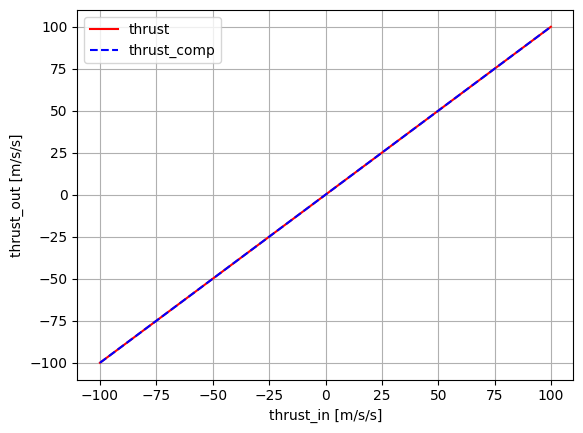

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# スラスター特性
def thruster(u):
    return np.where(np.abs(u) < 1.0, -u * 0.1, np.where(np.abs(u) < 20.0, -0.1 * u**3, -u * 40))

# ここを編集する
def thruster_comp(u):
    return u

u_in = np.arange(-100,100,0.1)

plt.plot(u_in, thruster(u_in), "r")
plt.plot(u_in, thruster_comp(thruster(u_in)), "b--")

plt.xlabel("thrust_in [m/s/s]")
plt.ylabel("thrust_out [m/s/s]")
plt.legend(["thrust", "thrust_comp"])
plt.grid(True)



# ロケットダイナミクス

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータ
m = 1.0  # ロケットの質量
l = 1.0  # ロケットの長さ
g = 9.81 # 重力加速度

# 初期状態ベクトル [px, py, vx, vy, theta, omega]
initial_state = np.array([0.0, 0.0, 0.0, 0.0, np.radians(6), 0.0])

# シミュレーションの時間設定
dt = 0.01  # 時間刻み
T  = 100   # 終了時間
steps = int(T / dt)

# システムダイナミクス
def rocket_dynamics(state, thrust_v, thrust_h):
    dx_dt, dy_dt, theta, omega = state
    dtheta_dt = omega
    domega_dt = (g / l) * np.sin(theta) - (1 / (m * l**2)) * thrust_v
    dvx_dt = thrust_h * np.cos(theta) - g
    dvy_dt = thrust_h * np.sin(theta)
    if dx_dt < 0.0:
        dx_dt = 0.0
    return np.array([dx_dt, dy_dt, dvx_dt, dvy_dt, dtheta_dt, domega_dt])

# フィードバックゲイン(自由に変更してよい)
# 制御
K = np.array([0, 0])
def control(state):
    # 水平、垂直方向の推力
    # 自由に変更してよい
    thrust_v = K.dot(state[4:])
    thrust_h = 20.0
    return thrust_v, thrust_h


# データ記録用
orbit_vals = []
# 現在の状態を初期状態で設定
state = initial_state.copy()

# シミュレーションループ
for i in range(steps):
    # 制御入力(変更してよい)
    thrust_v_in, thrust_h_in = control(state)
    thrust_v_comp = thruster_comp(thrust_v_in)
    thrust_h_comp = thruster_comp(thrust_h_in)
    thrust_v_out = thruster(thrust_v_comp)
    thrust_h_out = thruster(thrust_h_comp)

    # t時のダイナミクス (変更不可)
    dstate = rocket_dynamics(state[2:], thrust_v_out, thrust_h_out)

    # ステート更新 (変更不可)
    state += dstate * dt

    # ログ  (必要に応じて追加してよい)
    orbit_vals.append([state[0], state[1], state[4]])

orbit_vals = np.array(orbit_vals)
# 描画
plt.figure()
plt.plot([-1000,1000], [0,0], color="brown")
plt.plot([-1000,1000], [5000,5000], "g--")
plt.plot([-100,-100], [0,5000], "g--")
plt.plot([100,100], [0,5000], "g--")

plt.plot(orbit_vals[:,1], orbit_vals[:,0])
plt.grid(True)
plt.xlabel("Horizontal [m]")
plt.ylabel("Attitude [m]")


Text(0, 0.5, 'Attitude [m]')

# アニメーション

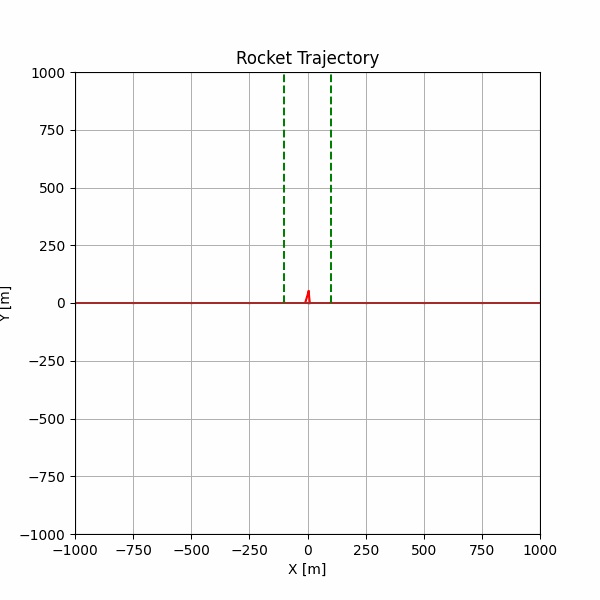

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, Image

# アニメーションの設定
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Rocket Trajectory')
ax.grid(True)
line, = ax.plot([], [], 'b--')
rocket, = ax.plot([], [], 'r-')
ground, = ax.plot([-10000,10000], [0,0], color="brown")
minimum_line, = ax.plot([-10000,10000], [5000,5000], "g--")
full_line1, = ax.plot([-100,-100], [0,100000], "g--")
full_line2, = ax.plot([100,100], [0,100000], "g--")

def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

def rotate_rocket(rocket_coords, theta):
    rotated_coords = np.dot(rotation_matrix(theta), rocket_coords.T).T
    return rotated_coords

def init():
    pass
# アニメーションの更新関数
def animate(i):
    line.set_data(orbit_vals[:i*100+1, 1], orbit_vals[:i*100+1, 0])

    # ロケットの姿勢角度を取得
    theta = orbit_vals[i*100,2]

    # ロケットの初期座標 (例: 三角形)
    rocket_coords = np.array([
        [0, 50],
        [-10, 0.0],
        [ 10, 0.0],
        [0, 50]
    ])

    # ロケットの座標を回転
    rotated_coords = rotate_rocket(rocket_coords, -theta)

    # ロケットのプロットを更新
    rocket.set_data(rotated_coords[:, 0] + np.array(orbit_vals)[i*100, 1],
                    rotated_coords[:, 1] + np.array(orbit_vals)[i*100, 0])
    ax.set_xlim(np.array(orbit_vals)[i*100, 1] - 1000, np.array(orbit_vals)[i*100, 1] + 1000)
    ax.set_ylim(np.array(orbit_vals)[i*100, 0] - 1000, np.array(orbit_vals)[i*100, 0] + 1000)


# アニメーションの作成
ani = FuncAnimation(fig, animate, init_func=init, frames=len(np.array(orbit_vals)[::100,:]), interval=100)

# GIFへの保存
ani.save('rocket_trajectory.gif', writer='pillow', fps=30)
plt.close(fig)
# Colabでアニメーションを表示
display(Image(filename=f'rocket_trajectory.gif'))